## Set-up

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
import os
os.chdir('drive/MyDrive/Colab Notebooks/histopathology-cancer-classification')
sys.path.append('src')

In [3]:
!ls

 data
 deep-set-and-gnn.ipynb
 deep-set-end-to-end.ipynb
 deep-set-from-extracted-features.ipynb
 deep-set.ipynb
 deep-set-multiple.ipynb
 feature_extraction.ipynb
 feature_extraction_train.ipynb
 Graph_MIL.ipynb
 model_checkpoint.pt
 README.md
'Sean-testing-Copy of graph-neural-network.ipynb'
 src


In [4]:
!pip install torchinfo

In [5]:
!pip install imbalanced-learn==0.8.0

In [6]:
import time
import copy
import pickle
import math
import random
from PIL import Image
from pathlib import Path
from collections import Counter

import pandas as pd
import numpy as np
import seaborn as sns
import imblearn
from tqdm.notebook import tqdm
from matplotlib import pylab as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F
from torch import optim, nn
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from torchinfo import summary

## Utility

In [7]:
def get_device():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Current device: {:s}".format(device.type))
    return device

In [8]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [9]:
def get_wsis_features_labels(root, files):
    all_wsis = []
    all_features = []
    all_labels = []
    for i, f in enumerate(files):
        path = root + '/' + f
        if not os.path.exists(path):
            print("{} does not exist!".format(path))
            continue
        infile = open(path, 'rb')
        raw = pickle.load(infile)
        for wsi, features in raw.items():
            all_wsis.append(wsi)
            all_features.append(list(features.values()))
            all_labels.append(i)
    all_wsis = np.array(all_wsis, dtype=object)
    all_features = np.array(all_features, dtype=object)
    all_labels = np.array(all_labels, dtype=int)
    return all_wsis, all_features, all_labels

In [10]:
def oversample_dataset(wsis, features, labels):
    smote = imblearn.over_sampling.SMOTE(
        # sampling_strategy={0:150, 1:156, 2:20},
        sampling_strategy='auto',
        random_state=seed,
        k_neighbors=3
    )
    indices = np.arange(len(labels))
    indices = np.reshape(indices, (-1, 1))
    indices_sm, labels_sm = smote.fit_resample(indices, labels)
    wsis_sm = wsis[indices_sm.flatten()]
    features_sm = features[indices_sm.flatten()]
    return wsis_sm, features_sm, labels_sm

In [11]:
def shuffle(wsis, features, labels):
    idx = np.random.permutation(len(wsis))
    return wsis[idx], features[idx], labels[idx]

In [12]:
def plot_statistics(measure, values):
    fig = plt.figure(figsize=(10, 5))
    plt.title("Measure: {}".format(measure))
    for label, value in values.items():
        plt.plot(value, label=label)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel(measure)
    plt.legend(loc='best')

In [13]:
def plot_cm(labels, preds):
    fig = plt.figure(figsize=(6, 6))
    cm = pd.crosstab(labels, preds,
                     rownames=['Actual'], colnames=['Predicted'])
    sns.heatmap(cm, annot=True)
    plt.show()

## Global

In [14]:
seed = 647

In [15]:
batch_size = 16

In [16]:
num_patches = 30

In [17]:
in_features = 1024

In [18]:
data_roots = {
    'train' : 'data/train',
    'dev' : 'data/dev'
}

In [19]:
data_files = {
    'train' : ['LUAD_256_features_maxpool.pickle',
               'LUSC_256_features_maxpool.pickle',
               'MESO_256_features_maxpool.pickle'],
    'dev' : ['LUAD_DEV_256_features_maxpool.pickle',
             'LUSC_DEV_256_features_maxpool.pickle',
             'MESO_DEV_256_features_maxpool.pickle']
}

In [20]:
device = get_device()

Current device: cuda


## Data

In [21]:
class HistoDataset(Dataset):
    def __init__(self, wsis, features, labels, num_patches):
        """
        @param wsis: WSI filenames
        @param features: 2D array of features
        @param labels: Labels - {0 : LUAD, 1 : LUSC, 2 : MESO}
        @param num_patches: Number of patches per set to return
        """
        self.wsis = wsis
        self.features = features
        self.labels = labels
        self.num_patches = num_patches
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        wsi, features, label = self.wsis[index], self.features[index], self.labels[index]
        if len(features) == 0:
            raise FileExistsError
        features = self._get_random_features(features)
        input_mask = self._get_input_mask(features)
        input_tensor = self._get_input_tensor(features)
        assert input_mask.shape[0] == self.num_patches
        assert input_tensor.shape[0] == self.num_patches
        return wsi, input_tensor, input_mask, label
    
    def _get_random_features(self, features):
        if len(features) <= self.num_patches:
            return random.sample(features, len(features))
        return random.sample(features, self.num_patches)
    
    def _get_input_mask(self, features):
        num_images = len(features)
        num_empties = self.num_patches - num_images
        return torch.BoolTensor([True] * num_images + [False] * num_empties)
    
    def _get_input_tensor(self, features):
        input_tensor = torch.stack(features, dim = 0)
        P, C = input_tensor.shape
        if P == self.num_patches:
            return input_tensor
        input_tensor_padded = torch.zeros(size=(self.num_patches, C))
        for i in range(P):
            input_tensor_padded[i] = input_tensor[i]
        return input_tensor_padded

### Datasets

In [22]:
def create_dataset(root, files, oversample = True):
    wsis, features, labels = get_wsis_features_labels(root, files)
    if oversample:
        wsis, features, labels = oversample_dataset(wsis, features, labels)
    wsis, features, labels = shuffle(wsis, features, labels)
    dataset = HistoDataset(
        wsis = wsis,
        features = features,
        labels = labels,
        num_patches = num_patches
    )
    return dataset

In [23]:
set_seed(seed)

train_dataset = create_dataset(data_roots['train'], data_files['train'], oversample = True)
dev_dataset = create_dataset(data_roots['dev'], data_files['dev'], oversample = False)

In [24]:
Counter(train_dataset.labels)

Counter({0: 156, 1: 156, 2: 156})

In [25]:
Counter(dev_dataset.labels)

Counter({0: 38, 1: 41, 2: 5})

### Dataloaders

In [26]:
train_dataloader = DataLoader(
    dataset = train_dataset,
    batch_size = batch_size,
    shuffle = False
)

dev_dataloader = DataLoader(
    dataset = dev_dataset,
    batch_size = batch_size,
    shuffle = False
)

In [27]:
dataloaders = {
    'train' : train_dataloader,
    'dev' : dev_dataloader
}

In [28]:
for dtype, dl in dataloaders.items():
    print("{} has {} batches".format(dtype, len(dl)))

train has 30 batches
dev has 6 batches


### Example

In [29]:
ex_batch = next(iter(train_dataloader))

In [30]:
ex_input_tensors = ex_batch[1].to(device)

In [31]:
ex_input_tensors.shape

torch.Size([16, 30, 1024])

In [32]:
ex_input_masks = ex_batch[2].to(device)

In [33]:
ex_input_masks.shape

torch.Size([16, 30])

In [34]:
ex_labels = ex_batch[3].to(device)

In [35]:
ex_labels.shape

torch.Size([16])

In [36]:
ex_labels

tensor([1, 2, 1, 2, 1, 0, 2, 1, 1, 1, 1, 0, 1, 1, 1, 0], device='cuda:0')

## Model

### Dense

In [37]:
class Dense(nn.Module):
  def __init__(self):
    super(Dense, self).__init__()
    self.fc1 = nn.Linear(in_features=in_features, out_features=512)
  
  def forward(self, x, mask=None):
    # x is in shape (batch_size, num_patches, 1024)
    x = self.fc1(x)
    x = torch.tanh(x)
    # transform mask into (batch_size, num_patches, 1)
    N, M, _ = x.shape
    device = x.device
    if mask is None:
        mask = torch.ones(N, M).byte().to(device)
    mask = mask.unsqueeze(-1).float()
    # we don't want to propogate on non-images
    x = x * mask
    return x

### Deep Set

In [38]:
class InvLinear(nn.Module):
    r"""Permutation invariant linear layer.
    Args:
        in_features: size of each input sample
        out_features: size of each output sample
        bias: If set to False, the layer will not learn an additive bias.
            Default: ``True``
        reduction: Permutation invariant operation that maps the input set into a single
            vector. Currently, the following are supported: mean, sum, max and min.
    """
    def __init__(self, in_features, out_features, bias=True, reduction='mean'):
        super(InvLinear, self).__init__()

        self.in_features = in_features
        self.out_features = out_features
        assert reduction in ['mean', 'sum', 'max', 'min'],  \
            '\'reduction\' should be \'mean\'/\'sum\'\'max\'/\'min\', got {}'.format(reduction)
        self.reduction = reduction

        self.beta = nn.Parameter(torch.Tensor(self.in_features,
                                              self.out_features))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(1, self.out_features))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.beta)
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.beta)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, X, mask=None):
        r"""
        Maps the input set X = {x_1, ..., x_M} to a vector y of dimension out_features,
        through a permutation invariant linear transformation of the form:
            $y = \beta reduction(X) + bias$
        Inputs:
        X: N sets of size at most M where each element has dimension in_features
           (tensor with shape (N, M, in_features))
        mask: binary mask to indicate which elements in X are valid (byte tensor
            with shape (N, M) or None); if None, all sets have the maximum size M.
            Default: ``None``.
        Outputs:
        Y: N vectors of dimension out_features (tensor with shape (N, out_features))
        """
        N, M, _ = X.shape
        device = X.device
        y = torch.zeros(N, self.out_features).to(device)
        if mask is None:
            mask = torch.ones(N, M).byte().to(device)

        if self.reduction == 'mean':
            sizes = mask.float().sum(dim=1).unsqueeze(1)
            Z = X * mask.unsqueeze(2).float()
            y = (Z.sum(dim=1) @ self.beta)/sizes

        elif self.reduction == 'sum':
            Z = X * mask.unsqueeze(2).float()
            y = Z.sum(dim=1) @ self.beta

        elif self.reduction == 'max':
            Z = X.clone()
            Z[~mask] = float('-Inf')
            y = Z.max(dim=1)[0] @ self.beta

        else:  # min
            Z = X.clone()
            Z[~mask] = float('Inf')
            y = Z.min(dim=1)[0] @ self.beta

        if self.bias is not None:
            y += self.bias

        return y

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}, reduction={}'.format(
            self.in_features, self.out_features,
            self.bias is not None, self.reduction)

### Classifier

In [39]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        # self.fc1 = nn.Linear(1024, 512)
        # self.d1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 128)
        self.d2 = nn.Dropout(0.25)
        self.fc3 = nn.Linear(128, 3)
    
    def forward(self, x):
        # x = self.fc1(x)
        # x = self.d1(x)
        # x = torch.relu(x)
        x = self.fc2(x)
        x = self.d2(x)
        x = torch.relu(x)
        x = self.fc3(x)
        return x

### All

In [40]:
class HistoModel(nn.Module):
    
    def __init__(self):
        super(HistoModel, self).__init__()
        self.model_dense = Dense()
        self.model_ds = InvLinear(512, 512, bias=True, reduction='mean')
        self.model_mlp = MLP()
        
    def forward(self, x, mask=None):
        x = self.model_dense(x, mask)
        x = self.model_ds(x, mask)
        x = self.model_mlp(x)
        return x

In [41]:
my_model = HistoModel()
my_model = my_model.to(device)

In [42]:
summary(my_model, input_size=(batch_size, num_patches, in_features))

Layer (type:depth-idx)                   Output Shape              Param #
├─Dense: 1-1                             [16, 30, 512]             --
|    └─Linear: 2-1                       [16, 30, 512]             524,800
├─InvLinear: 1-2                         [16, 512]                 262,656
├─MLP: 1-3                               [16, 3]                   --
|    └─Linear: 2-2                       [16, 128]                 65,664
|    └─Dropout: 2-3                      [16, 128]                 --
|    └─Linear: 2-4                       [16, 3]                   387
Total params: 853,507
Trainable params: 853,507
Non-trainable params: 0
Total mult-adds (M): 264.27
Input size (MB): 1.97
Forward/backward pass size (MB): 2.05
Params size (MB): 3.41
Estimated Total Size (MB): 7.43

In [43]:
ex_outputs = my_model(ex_input_tensors, ex_input_masks)

In [44]:
ex_outputs.shape

torch.Size([16, 3])

In [45]:
ex_outputs

tensor([[ 0.2894, -0.1338, -0.0200],
        [ 0.2490, -0.1508, -0.3403],
        [ 0.2720, -0.2094, -0.0356],
        [ 0.3314,  0.1434, -0.1490],
        [ 0.0742,  0.1010,  0.0477],
        [ 0.4154, -0.3358, -0.0700],
        [ 0.2102,  0.0229, -0.0173],
        [ 0.2092,  0.0892,  0.0119],
        [ 0.1734, -0.2442, -0.0723],
        [ 0.2779, -0.0592, -0.1164],
        [ 0.3085, -0.0777, -0.1893],
        [ 0.2201, -0.1662, -0.0157],
        [ 0.3180, -0.1299, -0.1121],
        [ 0.2473, -0.0418, -0.2363],
        [ 0.2229, -0.1835, -0.3038],
        [ 0.1604, -0.0531,  0.0118]], device='cuda:0', grad_fn=<AddmmBackward>)

## Train

In [46]:
def train(model, device, dataloaders, criterion, optimizer, num_epochs):
    # starting time
    since = time.time()

    # store model that yields the highest accuracy in the validation set
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_epoch = 0
    best_dev_labels = []
    best_dev_preds = []

    # keep track of the statistics
    losses = {'train': [], 'dev': []}
    accuracies = {'train': [], 'dev': []}

    # iterate through each epoch
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # each epoch has a training and dev phase
        for phase in ['train', 'dev']:
            if phase == 'train':
                model.train()  # set model to training mode
            else:
                model.eval()   # set model to evaluate mode

            # loss and number of correct predictions
            running_loss = 0.0
            running_corrects = 0
            running_data = 0
            running_labels = []
            running_preds = []

            # iterate over each batch
            with tqdm(dataloaders[phase], unit="batch") as tepoch:
                for batch in tepoch:
                    # Unravel inputs
                    _, inputs, masks, labels = batch
                    inputs = inputs.to(device)
                    masks = masks.to(device)
                    labels = labels.to(device)

                    # reset the parameter gradients
                    optimizer.zero_grad()
                    model.zero_grad()

                    # forward
                    # track history only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs, masks)
                        outputs = outputs.to(device)
                        loss = criterion(outputs, labels)
                        preds = torch.argmax(outputs, axis=1)

                        # backward only if in training
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                        
                        # record

                    # add to statistics
                    running_loss += loss.item() * len(labels)
                    running_corrects += torch.sum(
                        preds == labels.data.flatten()
                    )
                    running_data += len(labels)
                    running_labels.extend(labels.data.flatten().tolist())
                    running_preds.extend(preds.data.flatten().tolist())

                    # update progress bar
                    tepoch.set_postfix(
                        loss=(running_loss / running_data),
                        accuracy=(running_corrects.item() / running_data)
                    )
                    time.sleep(0.1)

            # compute loss and accuracy at epoch level
            epoch_loss = running_loss / running_data
            epoch_acc = running_corrects.double() / running_data
            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc)

            print('{} Loss: {:.4f}; Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc
            ))

            # deep copy the model when epoch accuracy (on dev set) is the best so far
            if phase == 'dev' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_epoch = epoch + 1
                best_dev_labels = running_labels
                best_dev_preds = running_preds
                torch.save(model, 'model_checkpoint.pt')
                print('Best model so far! Saved checkpoint.')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60
    ))
    print('Best Dev Acc: {:4f} at Epoch: {:d}'.format(best_acc, best_epoch))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_epoch, losses, accuracies, best_dev_labels, best_dev_preds

In [47]:
my_model = HistoModel()
my_model = my_model.to(device)

In [48]:
optimizer = optim.AdamW(
    my_model.parameters(),
    lr = 1e-6
)

In [49]:
criterion = nn.CrossEntropyLoss(weight = torch.FloatTensor([10, 10, 10]))
# criterion = nn.CrossEntropyLoss()

criterion = criterion.to(device)

In [50]:
set_seed(seed)

my_model, best_epoch, losses, accuracies, dev_labels, dev_preds = train(
    model = my_model,
    device = device,
    dataloaders = dataloaders,
    criterion = criterion,
    optimizer = optimizer,
    num_epochs = 100
)

Epoch 1/100
----------



train Loss: 1.1019; Acc: 0.3098



dev Loss: 1.0927; Acc: 0.4048
Best model so far! Saved checkpoint.

Epoch 2/100
----------



train Loss: 1.1017; Acc: 0.3248



dev Loss: 1.0910; Acc: 0.4286
Best model so far! Saved checkpoint.

Epoch 3/100
----------



train Loss: 1.0955; Acc: 0.3611



dev Loss: 1.0912; Acc: 0.4762
Best model so far! Saved checkpoint.

Epoch 4/100
----------



train Loss: 1.0942; Acc: 0.3504



dev Loss: 1.0879; Acc: 0.5238
Best model so far! Saved checkpoint.

Epoch 5/100
----------



train Loss: 1.0933; Acc: 0.3462



dev Loss: 1.0863; Acc: 0.5119

Epoch 6/100
----------



train Loss: 1.0895; Acc: 0.3953



dev Loss: 1.0832; Acc: 0.5476
Best model so far! Saved checkpoint.

Epoch 7/100
----------



train Loss: 1.0780; Acc: 0.4103



dev Loss: 1.0819; Acc: 0.4881

Epoch 8/100
----------



train Loss: 1.0794; Acc: 0.4167



dev Loss: 1.0810; Acc: 0.5595
Best model so far! Saved checkpoint.

Epoch 9/100
----------



train Loss: 1.0762; Acc: 0.4402



dev Loss: 1.0799; Acc: 0.5595

Epoch 10/100
----------



train Loss: 1.0723; Acc: 0.4765



dev Loss: 1.0800; Acc: 0.5595

Epoch 11/100
----------



train Loss: 1.0756; Acc: 0.4359



dev Loss: 1.0769; Acc: 0.5595

Epoch 12/100
----------



train Loss: 1.0673; Acc: 0.4979



dev Loss: 1.0752; Acc: 0.5595

Epoch 13/100
----------



train Loss: 1.0626; Acc: 0.5150



dev Loss: 1.0744; Acc: 0.6071
Best model so far! Saved checkpoint.

Epoch 14/100
----------



train Loss: 1.0645; Acc: 0.4936



dev Loss: 1.0742; Acc: 0.5952

Epoch 15/100
----------



train Loss: 1.0597; Acc: 0.5192



dev Loss: 1.0714; Acc: 0.5952

Epoch 16/100
----------



train Loss: 1.0636; Acc: 0.4957



dev Loss: 1.0717; Acc: 0.6190
Best model so far! Saved checkpoint.

Epoch 17/100
----------



train Loss: 1.0566; Acc: 0.5427



dev Loss: 1.0695; Acc: 0.6310
Best model so far! Saved checkpoint.

Epoch 18/100
----------



train Loss: 1.0531; Acc: 0.5299



dev Loss: 1.0687; Acc: 0.6190

Epoch 19/100
----------



train Loss: 1.0539; Acc: 0.5342



dev Loss: 1.0657; Acc: 0.6071

Epoch 20/100
----------



train Loss: 1.0467; Acc: 0.5427



dev Loss: 1.0687; Acc: 0.5833

Epoch 21/100
----------



train Loss: 1.0423; Acc: 0.5833



dev Loss: 1.0657; Acc: 0.5714

Epoch 22/100
----------



train Loss: 1.0474; Acc: 0.5726



dev Loss: 1.0650; Acc: 0.6190

Epoch 23/100
----------



train Loss: 1.0422; Acc: 0.5491



dev Loss: 1.0645; Acc: 0.6429
Best model so far! Saved checkpoint.

Epoch 24/100
----------



train Loss: 1.0430; Acc: 0.5598



dev Loss: 1.0622; Acc: 0.6429

Epoch 25/100
----------



train Loss: 1.0355; Acc: 0.5812



dev Loss: 1.0630; Acc: 0.6310

Epoch 26/100
----------



train Loss: 1.0338; Acc: 0.6068



dev Loss: 1.0629; Acc: 0.6310

Epoch 27/100
----------



train Loss: 1.0333; Acc: 0.6047



dev Loss: 1.0596; Acc: 0.6190

Epoch 28/100
----------



train Loss: 1.0317; Acc: 0.6004



dev Loss: 1.0598; Acc: 0.5952

Epoch 29/100
----------



train Loss: 1.0258; Acc: 0.6496



dev Loss: 1.0598; Acc: 0.6310

Epoch 30/100
----------



train Loss: 1.0285; Acc: 0.6218



dev Loss: 1.0559; Acc: 0.6310

Epoch 31/100
----------



train Loss: 1.0258; Acc: 0.6325



dev Loss: 1.0534; Acc: 0.6310

Epoch 32/100
----------



train Loss: 1.0226; Acc: 0.6239



dev Loss: 1.0553; Acc: 0.5952

Epoch 33/100
----------



train Loss: 1.0221; Acc: 0.6068



dev Loss: 1.0491; Acc: 0.6429

Epoch 34/100
----------



train Loss: 1.0165; Acc: 0.6453



dev Loss: 1.0500; Acc: 0.6667
Best model so far! Saved checkpoint.

Epoch 35/100
----------



train Loss: 1.0106; Acc: 0.6517



dev Loss: 1.0488; Acc: 0.6548

Epoch 36/100
----------



train Loss: 1.0118; Acc: 0.6346



dev Loss: 1.0506; Acc: 0.6429

Epoch 37/100
----------



train Loss: 1.0086; Acc: 0.6496



dev Loss: 1.0499; Acc: 0.6310

Epoch 38/100
----------



train Loss: 1.0110; Acc: 0.6624



dev Loss: 1.0462; Acc: 0.6667

Epoch 39/100
----------



train Loss: 1.0049; Acc: 0.6496



dev Loss: 1.0508; Acc: 0.6071

Epoch 40/100
----------



train Loss: 1.0039; Acc: 0.6731



dev Loss: 1.0474; Acc: 0.6429

Epoch 41/100
----------



train Loss: 0.9992; Acc: 0.6795



dev Loss: 1.0448; Acc: 0.6667

Epoch 42/100
----------



train Loss: 0.9960; Acc: 0.6752



dev Loss: 1.0424; Acc: 0.6429

Epoch 43/100
----------



train Loss: 0.9891; Acc: 0.6731



dev Loss: 1.0440; Acc: 0.6310

Epoch 44/100
----------



train Loss: 0.9936; Acc: 0.6496



dev Loss: 1.0413; Acc: 0.6429

Epoch 45/100
----------



train Loss: 0.9922; Acc: 0.6752



dev Loss: 1.0421; Acc: 0.6667

Epoch 46/100
----------



train Loss: 0.9843; Acc: 0.6859



dev Loss: 1.0425; Acc: 0.5952

Epoch 47/100
----------



train Loss: 0.9849; Acc: 0.6859



dev Loss: 1.0398; Acc: 0.6429

Epoch 48/100
----------



train Loss: 0.9807; Acc: 0.7030



dev Loss: 1.0388; Acc: 0.6190

Epoch 49/100
----------



train Loss: 0.9754; Acc: 0.6987



dev Loss: 1.0377; Acc: 0.6310

Epoch 50/100
----------



train Loss: 0.9806; Acc: 0.6667



dev Loss: 1.0350; Acc: 0.6548

Epoch 51/100
----------



train Loss: 0.9740; Acc: 0.6774



dev Loss: 1.0324; Acc: 0.6429

Epoch 52/100
----------



train Loss: 0.9745; Acc: 0.6688



dev Loss: 1.0325; Acc: 0.6429

Epoch 53/100
----------



train Loss: 0.9679; Acc: 0.7030



dev Loss: 1.0311; Acc: 0.6429

Epoch 54/100
----------



train Loss: 0.9656; Acc: 0.7179



dev Loss: 1.0332; Acc: 0.6071

Epoch 55/100
----------



train Loss: 0.9642; Acc: 0.6838



dev Loss: 1.0316; Acc: 0.6548

Epoch 56/100
----------



train Loss: 0.9644; Acc: 0.7073



dev Loss: 1.0271; Acc: 0.6310

Epoch 57/100
----------



train Loss: 0.9562; Acc: 0.7158



dev Loss: 1.0268; Acc: 0.6071

Epoch 58/100
----------



train Loss: 0.9575; Acc: 0.7073



dev Loss: 1.0235; Acc: 0.6310

Epoch 59/100
----------



train Loss: 0.9528; Acc: 0.7137



dev Loss: 1.0238; Acc: 0.6310

Epoch 60/100
----------



train Loss: 0.9528; Acc: 0.7201



dev Loss: 1.0233; Acc: 0.6310

Epoch 61/100
----------



train Loss: 0.9517; Acc: 0.7009



dev Loss: 1.0244; Acc: 0.6310

Epoch 62/100
----------



train Loss: 0.9428; Acc: 0.7158



dev Loss: 1.0209; Acc: 0.6548

Epoch 63/100
----------



train Loss: 0.9479; Acc: 0.7158



dev Loss: 1.0119; Acc: 0.6429

Epoch 64/100
----------



train Loss: 0.9408; Acc: 0.7222



dev Loss: 1.0234; Acc: 0.6429

Epoch 65/100
----------



train Loss: 0.9344; Acc: 0.7286



dev Loss: 1.0142; Acc: 0.6429

Epoch 66/100
----------



train Loss: 0.9362; Acc: 0.7244



dev Loss: 1.0199; Acc: 0.6310

Epoch 67/100
----------



train Loss: 0.9312; Acc: 0.7457



dev Loss: 1.0158; Acc: 0.6548

Epoch 68/100
----------



train Loss: 0.9350; Acc: 0.7179



dev Loss: 1.0233; Acc: 0.6190

Epoch 69/100
----------



train Loss: 0.9298; Acc: 0.7265



dev Loss: 1.0080; Acc: 0.6429

Epoch 70/100
----------



train Loss: 0.9258; Acc: 0.7244



dev Loss: 1.0152; Acc: 0.6548

Epoch 71/100
----------



train Loss: 0.9262; Acc: 0.7009



dev Loss: 1.0091; Acc: 0.6667

Epoch 72/100
----------



train Loss: 0.9169; Acc: 0.7415



dev Loss: 1.0118; Acc: 0.6548

Epoch 73/100
----------



train Loss: 0.9129; Acc: 0.7436



dev Loss: 1.0064; Acc: 0.6548

Epoch 74/100
----------



train Loss: 0.9128; Acc: 0.7350



dev Loss: 1.0047; Acc: 0.6786
Best model so far! Saved checkpoint.

Epoch 75/100
----------



train Loss: 0.9155; Acc: 0.7179



dev Loss: 1.0159; Acc: 0.5952

Epoch 76/100
----------



train Loss: 0.9026; Acc: 0.7372



dev Loss: 1.0076; Acc: 0.6429

Epoch 77/100
----------



train Loss: 0.8997; Acc: 0.7415



dev Loss: 1.0125; Acc: 0.6310

Epoch 78/100
----------



train Loss: 0.9088; Acc: 0.7308



dev Loss: 1.0011; Acc: 0.6667

Epoch 79/100
----------



train Loss: 0.8973; Acc: 0.7393



dev Loss: 1.0123; Acc: 0.6429

Epoch 80/100
----------



train Loss: 0.9079; Acc: 0.7350



dev Loss: 1.0106; Acc: 0.6190

Epoch 81/100
----------



train Loss: 0.8956; Acc: 0.7415



dev Loss: 1.0112; Acc: 0.6667

Epoch 82/100
----------



train Loss: 0.8989; Acc: 0.7350



dev Loss: 1.0113; Acc: 0.6548

Epoch 83/100
----------



train Loss: 0.8940; Acc: 0.7329



dev Loss: 1.0047; Acc: 0.6190

Epoch 84/100
----------



train Loss: 0.8835; Acc: 0.7650



dev Loss: 1.0026; Acc: 0.6667

Epoch 85/100
----------



train Loss: 0.8882; Acc: 0.7650



dev Loss: 1.0027; Acc: 0.6548

Epoch 86/100
----------



train Loss: 0.8809; Acc: 0.7585



dev Loss: 1.0001; Acc: 0.6310

Epoch 87/100
----------



train Loss: 0.8799; Acc: 0.7479



dev Loss: 0.9962; Acc: 0.6190

Epoch 88/100
----------



train Loss: 0.8833; Acc: 0.7329



dev Loss: 0.9925; Acc: 0.6429

Epoch 89/100
----------



train Loss: 0.8719; Acc: 0.7585



dev Loss: 0.9931; Acc: 0.6429

Epoch 90/100
----------



train Loss: 0.8732; Acc: 0.7415



dev Loss: 1.0003; Acc: 0.6310

Epoch 91/100
----------



train Loss: 0.8681; Acc: 0.7350



dev Loss: 0.9905; Acc: 0.6429

Epoch 92/100
----------



train Loss: 0.8644; Acc: 0.7479



dev Loss: 0.9860; Acc: 0.6429

Epoch 93/100
----------



train Loss: 0.8658; Acc: 0.7543



dev Loss: 0.9937; Acc: 0.6786

Epoch 94/100
----------



train Loss: 0.8629; Acc: 0.7521



dev Loss: 0.9825; Acc: 0.6667

Epoch 95/100
----------



train Loss: 0.8650; Acc: 0.7543



dev Loss: 0.9881; Acc: 0.6905
Best model so far! Saved checkpoint.

Epoch 96/100
----------



train Loss: 0.8538; Acc: 0.7521



dev Loss: 0.9755; Acc: 0.6548

Epoch 97/100
----------



train Loss: 0.8552; Acc: 0.7350



dev Loss: 0.9861; Acc: 0.6190

Epoch 98/100
----------



train Loss: 0.8492; Acc: 0.7457



dev Loss: 0.9875; Acc: 0.6429

Epoch 99/100
----------



train Loss: 0.8562; Acc: 0.7628



dev Loss: 0.9892; Acc: 0.6548

Epoch 100/100
----------



train Loss: 0.8488; Acc: 0.7479



dev Loss: 0.9906; Acc: 0.6548

Training complete in 6m 58s
Best Dev Acc: 0.690476 at Epoch: 95


### Results

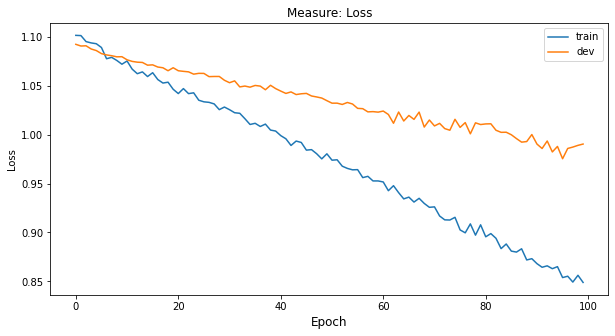

In [54]:
plot_statistics('Loss', losses)

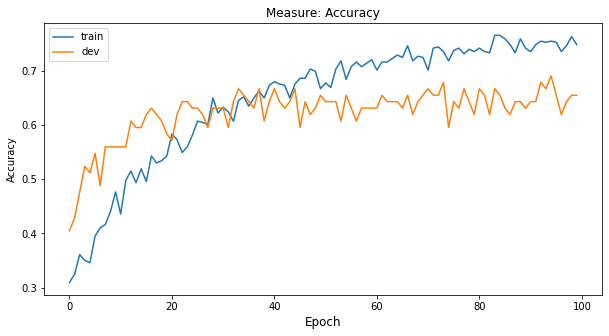

In [55]:
plot_statistics('Accuracy', accuracies)

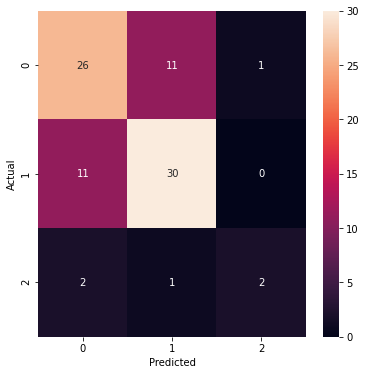

In [56]:
plot_cm(np.array(dev_labels), np.array(dev_preds))